In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# LOAD DATA


NOTE: SS_cons symbols can be looked up in the infernal dokumentation

definition block:  bunch of adjacent < or > in the structure, now adding all other stems and a counter 

len + lennogap ,count   ,, length of alignments sometimes removing gaps, number of sequences in the alignment

aliX , ali1, ali2 , removing badly aligned sequences: 20%, 1 ,2   
calculation: rank sequences by outlier-points: if a column has 1 '.', or all but 1 '.' count an outlier-point

filtered: removing blocks of ~size~ len <3

flank: selected the positions that are within 5nuc of a block

cons, cov:  
calculation: mean([(max(Y,R)> .5 and (number of dots) else 0) / count])  
calculation: mean([(max(character) / count] and . becomes 0)  
calculation: cov/len 

stem length last-1: size of the second largest block 




In [2]:
debug = False
numneg = 800
randseed = 42
use_rnaz = False
blacklist_file = "noblacklist"

import sys
import os
#sys.path.append("../")
#os.symlink("../data", "data")
from sklearn.model_selection import train_test_split
import input.loadfiles as loadfiles
p,n  = loadfiles.loaddata("data", numneg, randseed, use_rnaz, 'both', blacklist_file=blacklist_file)

No Blacklist found in noblacklist
loadfiles.py: removing some positives


# Make a pandas dataframe, 

In [3]:
import pandas as pd
import copy

def clean(di,oklist):
    for k in list(di.keys()):
        if k not in oklist:
            di.pop(k)
    return di

def makeXY(featurelist):
    asd = [ clean(e,featurelist) for e in copy.deepcopy(p+n) ]
    df = pd.DataFrame(asd)
    df = df.transpose().drop_duplicates().transpose() # Remove Duplicates
    X= df.to_numpy()
    y= [1]*len(p)+[0]*len(n)
    return X,y,df


allfeatures = list(p[1].keys()) # the filenames are the last one and we dont need that (for now)
allfeatures.remove("name")
X,Y,df = makeXY(allfeatures)

# check if is nan
from IPython.display import display, HTML
display(HTML(df[df.isna().any(axis=1)].head().to_html()))

,total_conservation,total_conservation_+cov,total_conservation_nuc,total_conservation_nuc_+cov,number_of_<_blocks,number_of_(_blocks,number_of_[_blocks,number_of_{_blocks,stem_length_smallest,stem_length_last-1,stem_length_max,stem_cons,stem_cons_nuc,flank_cons,flank_cons_nuc,perc_stem,length,count,stem_covariance,sloppy_gu,sloppy_all,big_mysterious_hairpin,remove_1/3_seq total_conservation,remove_1/3_seq total_conservation_+cov,remove_1/3_seq total_conservation_nuc,remove_1/3_seq total_conservation_nuc_+cov,remove_1/3_seq number_of_<_blocks,remove_1/3_seq number_of_(_blocks,remove_1/3_seq number_of_[_blocks,remove_1/3_seq number_of_{_blocks,remove_1/3_seq stem_length_smallest,remove_1/3_seq stem_length_last-1,remove_1/3_seq stem_length_max,remove_1/3_seq stem_cons,remove_1/3_seq stem_cons_nuc,remove_1/3_seq flank_cons,remove_1/3_seq flank_cons_nuc,remove_1/3_seq perc_stem,remove_1/3_seq length,remove_1/3_seq count,remove_1/3_seq stem_covariance,remove_1/3_seq sloppy_gu,remove_1/3_seq sloppy_all,remove_1/3_seq big_mysterious_hairpin,remove_1_seq total_conservation,remove_1_seq total_conservation_+cov,remove_1_seq total_conservation_nuc,remove_1_seq total_conservation_nuc_+cov,remove_1_seq number_of_<_blocks,remove_1_seq number_of_(_blocks,remove_1_seq number_of_[_blocks,remove_1_seq stem_length_smallest,remove_1_seq stem_length_last-1,remove_1_seq stem_length_max,remove_1_seq stem_cons,remove_1_seq stem_cons_nuc,remove_1_seq flank_cons,remove_1_seq flank_cons_nuc,remove_1_seq perc_stem,remove_1_seq length,remove_1_seq count,remove_1_seq stem_covariance,remove_1_seq sloppy_gu,remove_1_seq sloppy_all,remove_1_seq big_mysterious_hairpin,remove_2_seq total_conservation,remove_2_seq total_conservation_+cov,remove_2_seq total_conservation_nuc,remove_2_seq total_conservation_nuc_+cov,remove_2_seq number_of_<_blocks,remove_2_seq number_of_(_blocks,remove_2_seq number_of_[_blocks,remove_2_seq stem_length_smallest,remove_2_seq stem_length_last-1,remove_2_seq stem_length_max,remove_2_seq stem_cons,remove_2_seq stem_cons_nuc,remove_2_seq flank_cons,remove_2_seq flank_cons_nuc,remove_2_seq perc_stem,remove_2_seq length,remove_2_seq count,remove_2_seq stem_covariance,remove_2_seq sloppy_gu,remove_2_seq sloppy_all,remove_2_seq big_mysterious_hairpin,rm_small_stems total_conservation_+cov,rm_small_stems total_conservation_nuc_+cov,rm_small_stems number_of_<_blocks,rm_small_stems number_of_(_blocks,rm_small_stems number_of_[_blocks,rm_small_stems number_of_{_blocks,rm_small_stems stem_length_smallest,rm_small_stems stem_length_last-1,rm_small_stems stem_length_max,rm_small_stems stem_cons,rm_small_stems stem_cons_nuc,rm_small_stems flank_cons,rm_small_stems flank_cons_nuc,rm_small_stems perc_stem,rm_small_stems stem_covariance,rm_small_stems sloppy_gu,rm_small_stems sloppy_all,rm_small_stems big_mysterious_hairpin,rm_small_stems remove_1/3_seq total_conservation_+cov,rm_small_stems remove_1/3_seq total_conservation_nuc_+cov,rm_small_stems remove_1/3_seq number_of_<_blocks,rm_small_stems remove_1/3_seq number_of_(_blocks,rm_small_stems remove_1/3_seq number_of_[_blocks,rm_small_stems remove_1/3_seq number_of_{_blocks,rm_small_stems remove_1/3_seq stem_length_smallest,rm_small_stems remove_1/3_seq stem_length_last-1,rm_small_stems remove_1/3_seq stem_length_max,rm_small_stems remove_1/3_seq stem_cons,rm_small_stems remove_1/3_seq stem_cons_nuc,rm_small_stems remove_1/3_seq flank_cons,rm_small_stems remove_1/3_seq flank_cons_nuc,rm_small_stems remove_1/3_seq perc_stem,rm_small_stems remove_1/3_seq stem_covariance,rm_small_stems remove_1/3_seq sloppy_gu,rm_small_stems remove_1/3_seq sloppy_all,rm_small_stems remove_1/3_seq big_mysterious_hairpin,rm_small_stems remove_1_seq total_conservation_+cov,rm_small_stems remove_1_seq total_conservation_nuc_+cov,rm_small_stems remove_1_seq number_of_<_blocks,rm_small_stems remove_1_seq number_of_(_blocks,rm_small_stems remove_1_seq number_of_[_blocks,rm_small_stems remove_1_seq stem_length_smallest,rm_small_

# feature selection 

In [73]:
%%time
from sklearn.feature_selection import RFECV as rec
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest
import pandas as pd
X = StandardScaler().fit_transform(X)
from sklearn.linear_model import Lasso
from skrebate import ReliefF as relief
from sklearn.metrics import f1_score
from sklearn.svm import SVC


randseed = 42
testsize=.3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state=randseed) # USE THE SAME SEED AS BELOW! 

def scorer(esti,x,y):
    yh = esti.predict(x)
    return f1_score(y,yh)

def lasso(X_data,y_data,alpha=.06):
    mod = Lasso(alpha=alpha)
    mod.fit(X_data,y_data)
    #print(mod.sparse_coef_)
    return [b for a,b in zip(mod.coef_, df.columns) if a]


reli=relief()
reli.fit(X_train,y_train)


def relief(_,_2,param):
    #https://github.com/EpistasisLab/scikit-rebate
    #print(reli.top_features_)
    top_features = reli.top_features_[:param]
    return [ df.columns[top] for top in top_features]


def variance_threshold(X_data, y_data, threshold=0.0):
    clf = VarianceThreshold(threshold)
    clf.fit(X_data, y_data)
    return [b for a,b in zip(clf.get_support(), df.columns) if a]
    

def select_k_best(X_data, y_data, score_func=chi2, k=20):
    clf = SelectKBest(score_func, k)
    mini = 0
    for x in range(0, len(X_data)):
        mini = min(min(X_data[x]), mini)
    if mini < 0:
        for x in range(0, len(X_data)):
            for y in range(0, len(X_data[x])):
                X_data[x][y] -= mini
    clf.fit(X_data, y_data)
    return [b for a,b in zip(clf.get_support(), df.columns) if a]


rfecv_estimator = SVC(kernel="linear")

def rfecv(X_data, y_data, estimator, step=1, cv=3):
    clf = rec(estimator, step, cv)
    clf.fit(X_data, y_data)
    return [b for a,b in zip(clf.get_support(), df.columns) if a]


featurelists = [ selector(X_train,y_train) for selector in [ #lambda x,y: lasso(x,y,alpha=.05),
                                                 #lambda x,y: lasso(x,y,alpha=.01),
                                                 #lambda x,y: relief(x,y,40),
                                                 #lambda x,y: relief(x,y,60),
                                                 #lambda x,y: relief(x,y,80),
                                                 lambda x,y: variance_threshold(x,y, threshold=1), #98,99,1,101fe
                                                 #lambda x,y: variance_threshold(x,y, threshold=1.01)
                                                 #lambda x,y: variance_threshold(x,y, threshold=1.04),
                                                 #lambda x,y: select_k_best(x, y, k=20),
                                                 #lambda x,y: rfecv(x, y, rfecv_estimator, step=1)
                                               ]]
#featurelists.append(df.columns)
print(type(featurelists[0]))
tmp =  pd.DataFrame([ [ 1 if f in featurelist else 0 for f in df.columns  ] for featurelist in featurelists],columns = df.columns)
display(HTML(tmp.loc[:, (tmp != 0).any(axis=0)].to_html()))
for featurelist in featurelists:
    print(len(featurelist))

<class 'list'>


,number_of_(_blocks,stem_length_smallest,stem_length_max,stem_cons,stem_cons_nuc,length,sloppy_all,big_mysterious_hairpin,remove_1/3_seq number_of_(_blocks,remove_1/3_seq number_of_[_blocks,remove_1/3_seq stem_length_smallest,remove_1/3_seq stem_length_last-1,remove_1/3_seq stem_length_max,remove_1/3_seq stem_cons,remove_1/3_seq stem_cons_nuc,remove_1/3_seq perc_stem,remove_1/3_seq length,remove_1/3_seq stem_covariance,remove_1/3_seq sloppy_gu,remove_1/3_seq sloppy_all,remove_1/3_seq big_mysterious_hairpin,remove_1_seq number_of_(_blocks,remove_1_seq number_of_[_blocks,remove_1_seq stem_length_smallest,remove_1_seq stem_length_last-1,remove_1_seq stem_length_max,remove_1_seq stem_cons,remove_1_seq stem_cons_nuc,remove_1_seq flank_cons_nuc,remove_1_seq length,remove_1_seq stem_covariance,remove_1_seq sloppy_gu,remove_1_seq sloppy_all,remove_1_seq big_mysterious_hairpin,remove_2_seq number_of_(_blocks,remove_2_seq number_of_[_blocks,remove_2_seq stem_length_smallest,remove_2_seq stem_length_last-1,remove_2_seq stem_length_max,remove_2_seq stem_cons,remove_2_seq length,remove_2_seq sloppy_all,remove_2_seq big_mysterious_hairpin,rm_small_stems number_of_(_blocks,rm_small_stems number_of_{_blocks,rm_small_stems stem_length_max,rm_small_stems stem_cons,rm_small_stems stem_cons_nuc,rm_small_stems flank_cons,rm_small_stems flank_cons_nuc,rm_small_stems perc_stem,rm_small_stems stem_covariance,rm_small_stems sloppy_gu,rm_small_stems big_mysterious_hairpin,rm_small_stems remove_1/3_seq number_of_<_blocks,rm_small_stems remove_1/3_seq number_of_(_blocks,rm_small_stems remove_1/3_seq stem_length_smallest,rm_small_stems remove_1/3_seq stem_length_last-1,rm_small_stems remove_1/3_seq stem_length_max,rm_small_stems remove_1/3_seq stem_cons,rm_small_stems remove_1/3_seq stem_cons_nuc,rm_small_stems remove_1/3_seq flank_cons,rm_small_stems remove_1/3_seq flank_cons_nuc,rm_small_stems remove_1/3_seq perc_stem,rm_small_stems remove_1/3_seq stem_covariance,rm_small_stems remove_1/3_seq sloppy_gu,rm_small_stems remove_1/3_seq sloppy_all,rm_small_stems remove_1/3_seq big_mysterious_hairpin,rm_small_stems remove_1_seq number_of_<_blocks,rm_small_stems remove_1_seq number_of_(_blocks,rm_small_stems remove_1_seq stem_length_last-1,rm_small_stems remove_1_seq stem_length_max,rm_small_stems remove_1_seq stem_cons,rm_small_stems remove_1_seq stem_cons_nuc,rm_small_stems remove_1_seq flank_cons,rm_small_stems remove_1_seq flank_cons_nuc,rm_small_stems remove_1_seq perc_stem,rm_small_stems remove_1_seq stem_covariance,rm_small_stems remove_1_seq sloppy_gu,rm_small_stems remove_1_seq sloppy_all,rm_small_stems remove_2_seq number_of_<_blocks,rm_small_stems remove_2_seq number_of_(_blocks,rm_small_stems remove_2_seq number_of_{_blocks,rm_small_stems remove_2_seq stem_length_last-1,rm_small_stems remove_2_seq stem_length_max,rm_small_stems remove_2_seq stem_cons,rm_small_stems remove_2_seq stem_cons_nuc,rm_small_stems remove_2_seq flank_cons,rm_small_stems remove_2_seq flank_cons_nuc,rm_small_stems remove_2_seq perc_stem,rm_small_stems remove_2_seq stem_covariance,rm_small_stems remove_2_seq sloppy_gu,rm_small_stems remove_2_seq sloppy_all,rm_small_stems remove_2_seq big_mysterious_hairpin
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


94
Wall time: 13.4 s


# Custom Feature Selection - Returns Featurenames and their scores sorted 
Note: Executing Parameter search after this one will not work (though Parameter search is probably broken right now anyways because of the new file structure)

In [14]:
from sklearn.feature_selection import (RFECV, VarianceThreshold,
                                       chi2, SelectKBest)
from sklearn.linear_model import Lasso
from skrebate import ReliefF
from pprint import pprint

def kfold(X, y, n_splits=2, randseed=None, shuffle=True):
    """Applies KFold Cross Validation to the given data.
    Returns:
      splits (List): A list where each entry represents each fold with [X_train, X_test, y_train, y_test]
    """
    from sklearn.model_selection import StratifiedKFold
    splits = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=randseed)
    for train, test in kf.split(X, y):
        splits.append([X[train], X[test],
                      [y[i] for i in train], [y[i] for i in test]])
    return splits

######################

def lasso(X_data, y_data, df, alpha=.06):
    mod = Lasso(alpha=alpha)
    mod.fit(X_data, y_data)
    print(np.count_nonzero(mod.coef_))
    return [(a, b) for a, b in zip(mod.coef_, df.columns) if a]


def relief(X_data, y_data, df, param):
    reli = ReliefF()
    reli.fit(X_data, y_data)
    # https://github.com/EpistasisLab/scikit-rebate
    top_features = reli.top_features_[:param]
    print(len(top_features))
    return [(a, b) for a, b in zip(reli.feature_importances_[top_features], df.columns[top_features])]


def variance_threshold(X_data, y_data, df, threshold=0.0):
    clf = VarianceThreshold(threshold)
    clf.fit(X_data, y_data)
    support = clf.get_support(True)
    rcolumns = df.columns[support]
    rlist = [b for a, b in zip(clf.get_support(), df.columns) if a]
    for x in range(0, len(rcolumns)):
        if not rcolumns[x] == rlist[x]:
            print(rcolumns[x], rlist[x])
    print(len(support))
    return [(a, b) for a, b in zip(clf.variances_[support], df.columns[support])]


def select_k_best(X_data, y_data, df, k=20):
    score_func=chi2

    clf = SelectKBest(score_func, k=k)
    mini = 0
    for x in range(0, len(X_data)):
        mini = min(min(X_data[x]), mini)
    if mini < 0:
        for x in range(0, len(X_data)):
            for y in range(0, len(X_data[x])):
                X_data[x][y] -= mini
    clf.fit(X_data, y_data)
    support = clf.get_support(True)
    print(len(support))
    return [(a, b) for a, b in zip(clf.pvalues_[support], df.columns[support])]


def rfecv(X_data, y_data, df, step=1, cv=3):
    rfecv_estimator = SVC(kernel="linear")

    clf = RFECV(rfecv_estimator, step=step, cv=cv)
    clf.fit(X_data, y_data)
    #print(clf.grid_scores_)
    #print(len(clf.grid_scores_))
    support = clf.get_support(True)
    print(len(support))
    return [(a, b) for a, b in zip(clf.ranking_[support], df.columns[support])]

use_lasso = 1
use_varthresh = 1
use_kbest = 1
use_relief = 1
use_rfecv = 1

X = StandardScaler().fit_transform(X)
folds = kfold(X, Y, n_splits=2, randseed=randseed)
for X_train, X_test, y_train, y_test in folds:
    if use_lasso:
        for alpha in [.05, 0.1]: # Lasso
            print(f"---- Lasso {alpha} -----")
            pprint(sorted(lasso(X_train, y_train, df, alpha), reverse = True))
    if use_varthresh:
        for threshold in [.99, .995, 1, 1.005, 1.01]: # VarThresh [.99, .995, 1, 1.005, 1.01]
            print(f"---- VarThresh {threshold} -----")
            pprint(sorted(variance_threshold(X_train, y_train, df, threshold), reverse = True))
    if use_kbest:
        for k in [20]: # SelKBest
            print(f"---- SelKBest {k} -----")
            pprint(sorted(select_k_best(X_train, y_train, df, k), reverse = True))
    if use_relief:
        for features in [40, 60, 80]: # Relief
            print(f"---- Relief {features} -----")
            pprint(sorted(relief(X_train, y_train, df, features), reverse = True))
    if use_rfecv:
        for stepsize in [1, 2, 3]: # RFECV
            print(f"---- RFECV {stepsize} -----")
            pprint(sorted(rfecv(X_train, y_train, df, stepsize), reverse = True))
    break # Added this break since we dont really need the other folds for this...

---- Lasso 0.05 -----
13
[(0.058230506873432376, 'yao_score'),
 (0.04381422275592024, 'rm_small_stems number_of_(_blocks'),
 (0.04066592160837561, 'remove_2_seq length'),
 (0.03228000208866287, 'rm_small_stems remove_2_seq number_of_<_blocks'),
 (0.02738211663773256, 'rm_small_stems flank_cons'),
 (0.02534664422493533, 'rm_small_stems remove_1_seq stem_covariance'),
 (0.013835688309494278, 'rm_small_stems remove_1/3_seq stem_covariance'),
 (0.009543186916293495, 'rm_small_stems remove_1/3_seq sloppy_gu'),
 (0.007420739125346928, 'number_of_<_blocks'),
 (0.00221832458578741, 'rm_small_stems remove_2_seq stem_covariance'),
 (-0.0206099645750146, 'remove_1/3_seq sloppy_all '),
 (-0.03383839982979734, 'rm_small_stems remove_2_seq stem_length_max'),
 (-0.03473118718522907, 'remove_2_seq stem_length_max')]
---- Lasso 0.1 -----
3
[(0.03241260526581093, 'remove_2_seq length'),
 (0.024752632429183637, 'yao_score'),
 (-0.020419950318403265, 'rm_small_stems remove_2_seq stem_length_max')]
---- Va

# check performance for various classifiers

In [6]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
names = ["Nearest Neighbors","Linear SVM", "RBF SVM",
         #"Gaussian Process", # 2 slow
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA",'extra trees','gradient boosting']
res = []

for FEATURELIST in featurelists:  # loop over all the selectors 
    
    # make some data 
    X,y,df = makeXY(FEATURELIST)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state=randseed) # USE THE SAME SEED AS BELOW!

    classifiers = [
        KNeighborsClassifier(5),
        SVC(kernel="linear",class_weight='balanced', C=0.025),
        SVC(gamma=2, C=1,class_weight='balanced'),
        #SVC(),
        #GaussianProcessClassifier(1.0 * RBF(1.0)),
        DecisionTreeClassifier(max_depth=5,class_weight='balanced',min_samples_leaf=4),
        RandomForestClassifier(max_depth=9, n_estimators=30, class_weight='balanced'),
        #RandomForestClassifier(max_depth=5, n_estimators=25, max_features=5,class_weight='balanced'),
        MLPClassifier(alpha=.001, max_iter=2000),
        AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
        ExtraTreesClassifier(),
        GradientBoostingClassifier()
        ]

    def score(clf):
        clf.fit(X_train, y_train)
        return scorer(clf,X_test,np.array(y_test))
        
    res.append( [score(clf) for clf in classifiers] )
    
display(HTML(pd.DataFrame(res,columns=names).to_html()))

c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\arkanini\appdata\local\pro

,Nearest Neighbors,Linear SVM,RBF SVM,Decision Tree,Random Forest,Neural Net,AdaBoost,Naive Bayes,QDA,extra trees,gradient boosting
0,0.711111,0.800000,0.085714,0.720588,0.744186,0.700000,0.661017,0.702703,0.059701,0.731707,0.717949
1,0.639344,0.672414,0.627119,0.608000,0.633333,0.581197,0.625000,0.655172,0.677165,0.644068,0.661157
2,0.652174,0.732824,0.253165,0.569106,0.650794,0.708661,0.666667,0.661765,0.740157,0.586207,0.698413
3,0.609929,0.700000,0.000000,0.724832,0.666667,0.693548,0.744526,0.686131,0.724638,0.628099,0.727273
4,0.623188,0.800000,0.000000,0.677686,0.745763,0.634146,0.688000,0.681481,0.648649,0.622951,0.677686
5,0.661765,0.710744,0.000000,0.687500,0.700855,0.661017,0.655462,0.702703,0.618182,0.682171,0.730435
6,0.642336,0.615385,0.534483,0.595041,0.611570,0.624000,0.524590,0.671329,0.448980,0.634921,0.554622
7,0.724638,0.803150,0.000000,0.734694,0.736000,0.793388,0.763359,0.727273,0.458333,0.734375,0.784615
8,0.700000,0.815385,0.030303,0.705036,0.753846,0.806452,0.677419,0.736842,0.606897,0.759690,0.742424
9,0.738462,0.744526,0.620690,0.712329,0.724409,0.731707,0.650794,0.675159,0.731034,0.677165,0.737589


# LIKE ABOVE BUT WITH RANDOM PARAM SEARCH! 

In [38]:
%%time
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV as RSCV
import other.randomsearch as  rs

res = []
for FEATURELIST in featurelists:  # loop over all the selectors 
    
    # make some data 
    X,y,df = makeXY(FEATURELIST)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state=randseed) # USE THE SAME SEED AS BELOW! 
    print(len(X_train))
    print(len(X_test))

    def score(clf,param):
        searcher = RSCV(clf, 
                    param, 
                    n_iter=50 if not debug else 5, 
                    scoring=None,
                    n_jobs=4,
                    iid=False,
                    #fefit=True,
                    cv=4,
                    verbose=0,
                    pre_dispatch="2*n_jobs",
                    random_state=None,
                    error_score=np.nan,
                    return_train_score=False)
        searcher.fit(X_train, y_train)
        
        # print(searcher.best_params_)
        return scorer(searcher.best_estimator_,X_test,np.array(y_test))
        
    res.append( [score(clf,param) for clf,param in zip(rs.classifiers,rs.param_lists)] )
    
    #print ("#"*80)
display(HTML(pd.DataFrame(res,columns=rs.clfnames).to_html()))

236
102


c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


236
102


c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


,xtratrees,gradientboosting
0,0.833333,0.8
1,0.859259,0.8


Wall time: 5.47 s


In [8]:
%%time
from random_param_search_performance import random_param_search as rps, maketasks
debug=True
tasks = maketasks(featurelists, p, n, randseed, n_splits=2)
rps(tasks, debug=debug)

,neuralnet,xtratrees,gradientboosting
0,0.717172,0.709360,0.693069
1,0.819048,0.765550,0.782178
2,0.627451,0.604878,0.658009
3,0.656085,0.646766,0.633166
4,0.669903,0.620690,0.613208
5,0.636364,0.656250,0.663507
6,0.685714,0.666667,0.688372
7,0.704762,0.708738,0.701923
8,0.708134,0.720379,0.702970
9,0.699507,0.714976,0.746411


Wall time: 2min 34s


(array([[0.71717172, 0.70935961, 0.69306931],
        [0.81904762, 0.76555024, 0.78217822],
        [0.62745098, 0.60487805, 0.65800866],
        [0.65608466, 0.64676617, 0.63316583],
        [0.66990291, 0.62068966, 0.61320755],
        [0.63636364, 0.65625   , 0.66350711],
        [0.68571429, 0.66666667, 0.68837209],
        [0.7047619 , 0.70873786, 0.70192308],
        [0.70813397, 0.72037915, 0.7029703 ],
        [0.69950739, 0.71497585, 0.74641148],
        [0.67021277, 0.66666667, 0.69387755],
        [0.69406393, 0.70535714, 0.73394495],
        [0.60747664, 0.60913706, 0.60696517],
        [0.59296482, 0.59      , 0.61627907],
        [0.70935961, 0.73      , 0.74257426],
        [0.82629108, 0.76363636, 0.77511962],
        [0.68367347, 0.72815534, 0.7638191 ],
        [0.80365297, 0.72146119, 0.73488372],
        [0.73786408, 0.67298578, 0.66666667],
        [0.80203046, 0.74257426, 0.73267327],
        [0.73846154, 0.70050761, 0.72727273],
        [0.76097561, 0.75229358, 0

Confusion matrix, without normalization
[[56938 12935]
 [  464   424]]


c:\users\arkanini\appdata\local\programs\python\python38\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


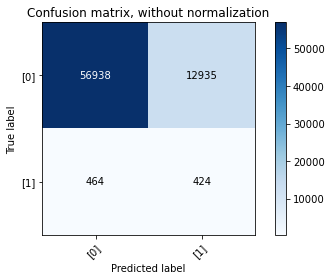

[0.05 0.1  0.05]


In [9]:
import other.logistic_regression as log_reg
cv = log_reg.log_reg(["data/yaoscores/pos.json", "data/yaoscores/pos2.json"], ["data/yaoscores/neg.json"])
print(cv)